<a href="https://colab.research.google.com/github/khalilouardini/IDRiD-challenge/blob/master/train_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('drive/My Drive/IDRiD-challenge')

In [35]:
!ls

classifier_utils.py  IDRiDClassifier.py       Segmentation_task
datasets	     IDRIDetectionDataset.py  train_classifier.ipynb
detection.ipynb      __pycache__


In [0]:
from IDRiDClassifier import IDRiDClassifier
from datasets.IDRiDGradingDataset import IDRiDGradingDataset
import copy
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
import numpy as np
import torch
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler

In [60]:
# Prepare data
root_dir_train = "/content/drive/My Drive/B. Disease Grading/1. Original Images/a. Training Set"
csv_file_train = "/content/drive/My Drive/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

root_dir_test = "/content/drive/My Drive/B. Disease Grading/1. Original Images/b. Testing Set"
csv_file_test = "/content/drive/My Drive/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"
bengraham = False

# transform (preprocessing)
scale = transforms.Resize((256, 256))
to_tensor = transforms.ToTensor()
composed = transforms.Compose([scale,
                               to_tensor])
# train and test set
train_set = IDRiDGradingDataset(csv_file_train, root_dir_train, composed, bengraham)
test_set = IDRiDGradingDataset(csv_file_test, root_dir_test, composed, bengraham)

#dataloaders
batch_size = 16
n = len(train_set)
train_indices = list(range(int(0.8*n)))
val_indices = list(range(int(0.8*n)+1, n))

train_loader = DataLoader(train_set, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_indices), num_workers=0)
val_loader = DataLoader(train_set, batch_size=batch_size,
                            sampler=SubsetRandomSampler(val_indices), num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size,
                            shuffle=True, num_workers=0)

print(f"# batches in train set {len(train_loader)} | # batches in val set {len(val_loader)}  # batches in test set {len(test_loader)  }")

# batches in train set 21 | # batches in val set 6  # batches in test set 7


In [0]:
# model
use_cuda = torch.cuda.is_available()
model = IDRiDClassifier()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    model = torch.nn.DataParallel(model)
model.to(device)

# intialize variables
n_epochs = 10
lr = 1e-4
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [0]:
import numpy as np
import torch
import pandas as pd
from copy import deepcopy
import pdb

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    """
    Method used to train our classifier

    Args:
        model: (nn.Module) the neural network
        train_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        n_epochs: (int) number of epochs performed during training

    Returns:
        best_model: (nn.Module) the trained neural network
    """
    best_model = deepcopy(model)
    val_best_loss = np.inf
    history_train = {'acc': [], 'loss': []}
    history_val = {'acc': [], 'loss': []}
    for epoch in range(n_epochs):
        model.train()
        for i, data in enumerate(train_loader, 0):
            # load batch
            images, labels = data['image'], data['labels']
            images = images.to(device)
            labels = labels.to(device)
            # - forward pass
            output = model.forward(images)
            # - loss computation
            loss = criterion(output, labels)
            # - backward pass (gradients computation)
            loss.backward()
            # - weights update
            optimizer.step()
            # - gradients set to 0
            optimizer.zero_grad()

        _, val_metrics = test(model, val_loader, criterion, device)
        _, train_metrics = test(model, train_loader, criterion, device)

        print('Train |Epoch %i: loss = %f | accuracy: %f | balanced accuracy = %f'
              % (epoch, train_metrics['mean_loss'],
                 train_metrics['accuracy'],
                 train_metrics['balanced_accuracy']))
        print('Validation |Epoch %i: loss = %f | accuracy: %f | balanced accuracy = %f'
              % (epoch, val_metrics['mean_loss'],
                 val_metrics['accuracy'],
                 val_metrics['balanced_accuracy']))
        print('\n')

        # history
        history_val['acc'].append(val_metrics['accuracy'])
        history_val['loss'].append(val_metrics['mean_loss'])
        history_train['acc'].append(train_metrics['accuracy'])
        history_train['loss'].append(train_metrics['mean_loss'])

        if val_metrics['mean_loss'] < val_best_loss:
            best_model = deepcopy(model)
            val_best_loss = val_metrics['mean_loss']

    return best_model, history_train, history_val


def test(model, data_loader, criterion, device):
    """
    Method used to test a CNN

    Args:
        model: (nn.Module) the model
        data_loader: (DataLoader) a DataLoader
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images

    Returns:
        results_df: (DataFrame) the label predicted for every subject
        results_metrics: (dict) a set of metrics
    """
    model.eval()
    columns = ["img_idx", "proba",
               "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].to(device), data['labels'].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            proba = torch.nn.Softmax(dim=1)(outputs)
            predictions, predicted_labels = torch.max(outputs.data, dim=1).values, torch.max(outputs.data, dim=1).indices
            for idx, _ in enumerate(labels):
                row = [idx, predictions[idx], labels[idx], predicted_labels[idx]]
                row_df = pd.DataFrame([row], columns=columns)
                results_df = pd.concat([results_df, row_df])

    results_metrics = compute_metrics(results_df.true_label.values, results_df.predicted_label.values)
    results_df.reset_index(inplace=True, drop=True)
    results_metrics['mean_loss'] = total_loss / len(data_loader.dataset)

    return results_df, results_metrics



def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity and balanced accuracy"""
    matches = 0
    for pred, gt in zip(prediction, ground_truth):
      if pred.item() == gt.item():
        matches += 1

    metrics_dict = dict()
    metrics_dict['accuracy'] = matches / prediction.size

    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))

    # Sensitivity
    if tp + fn != 0:
        metrics_dict['sensitivity'] = tp / (tp + fn)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if fp + tn != 0:
        metrics_dict['specificity'] = tn / (fp + tn)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2

    return metrics_dict

In [71]:
best_model, history_train, history_val = train(model, train_loader, val_loader, criterion, optimizer, n_epochs, device)

Train |Epoch 0: loss = 0.598428 | accuracy: 0.709091 | balanced accuracy = 0.500000
Validation |Epoch 0: loss = 0.235468 | accuracy: 0.475610 | balanced accuracy = 0.500000


Train |Epoch 1: loss = 0.587354 | accuracy: 0.721212 | balanced accuracy = 0.550401
Validation |Epoch 1: loss = 0.236638 | accuracy: 0.524390 | balanced accuracy = 0.500000


Train |Epoch 2: loss = 0.579890 | accuracy: 0.721212 | balanced accuracy = 0.661458
Validation |Epoch 2: loss = 0.235755 | accuracy: 0.500000 | balanced accuracy = 0.500000


Train |Epoch 3: loss = 0.568788 | accuracy: 0.742424 | balanced accuracy = 0.571429
Validation |Epoch 3: loss = 0.240814 | accuracy: 0.487805 | balanced accuracy = 0.500000


Train |Epoch 4: loss = 0.558061 | accuracy: 0.733333 | balanced accuracy = 0.571429
Validation |Epoch 4: loss = 0.236270 | accuracy: 0.512195 | balanced accuracy = 0.500000


Train |Epoch 5: loss = 0.550261 | accuracy: 0.760606 | balanced accuracy = 0.661565
Validation |Epoch 5: loss = 0.237700 | ac

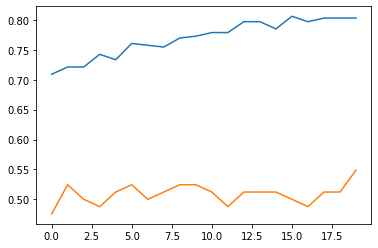

In [72]:
import matplotlib.pyplot as plt

plt.plot(history_train['acc'])
plt.plot(history_val['acc'])

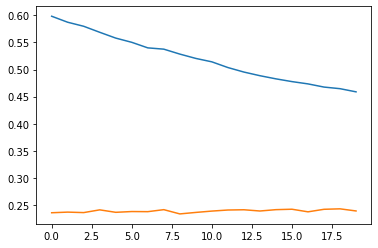

In [73]:
plt.plot(history_train['loss'])
plt.plot(history_val['loss'])

In [75]:
results_df, results_metrics = test(best_model, test_loader, criterion, device)
print(results_metrics)
print("done")

{'accuracy': 0.5048543689320388, 'sensitivity': 0.0, 'specificity': 1.0, 'balanced_accuracy': 0.5, 'mean_loss': 1.1176620409326645}
done
